# Counterfeit detection

The task in this assignment is to detect the  counterfeit banknotes. The data set is based on [banknote authentication Data Set ](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) from UCI Machine Learning repository. The first three columns denote different parameters obtained from the photographs of the banknotes and last colum provides the label. Frankly as the dataset does not have any description I don't know  which labels corresponds to real and which to counterfeited banknotes. let's assume that label one (positive) denotes the clounterfeits. The set  "banknote_authentication.csv" can be found in the data  directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import sys
sys.path.append("../../")

In [2]:
data = pd.read_csv('banknote_authentication.csv')

In [3]:
data.head()

,a1,a2,a3,counterfeit
0,12.3784,0.70403,-7.58360,0
1,8.1881,-3.13380,-2.52760,0
2,-10.8679,9.49260,-1.41160,1
3,-8.7903,7.97350,-0.45475,1
4,-5.5167,10.93900,-0.40820,1


## Problem 

### A.

Perform the Quadratic Discriminant Analysis on this set. Calculate the confusion matrix, AUC score and plot the ROC curve. 

First of all, we split the data:

In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve


features = data[['a1','a2','a3']]
labels = data['counterfeit']


train_data, test_data, train_labels, test_labels = train_test_split(features,labels, test_size=0.2)

Secondly, we copy the function 'analize' from the previous exercise:

In [5]:
def analize(cls, name, train_data, train_labels, test_data, test_labels):
    classifier = cls
    classifier.fit(train_data,train_labels)
    test_predicted = classifier.predict(test_data)
    test_pred_prob= classifier.predict_proba(test_data) #remember that this gives two columns
    fprs, tprs, thds  = roc_curve(test_labels, test_pred_prob[:,1],pos_label = 1)  
    tnr, fpr, fnr, tpr = confusion_matrix(test_labels, test_predicted,normalize='pred').ravel()
    auc = roc_auc_score(test_labels, test_pred_prob[:,1])
    return  pd.DataFrame({'TNR':[tnr],
                          'FNR':[fpr],
                          'FPR':[fnr],
                          'TPR':[tpr],
                          'Precision' : [precision_score(test_labels, test_predicted, average='macro')],
                          'F1' :[f1_score(test_labels, test_predicted, average='macro')],
                          'AUC' :[auc]
                           }, index=[name]), fprs, tprs, thds, auc

Now we call the function for QDA anc for our dataset:

In [6]:
qda = QuadraticDiscriminantAnalysis()

df,fprs,tprs,thds,auc = analize(qda, 'QDA' , train_data, train_labels, test_data, test_labels)

Confusion matrix, normalized and not normalized:

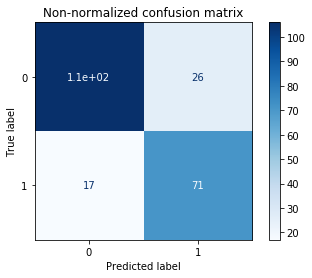

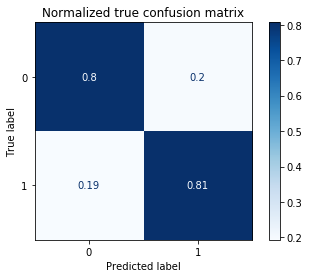

In [7]:
confusion_plot = plot_confusion_matrix(qda, test_data, test_labels,cmap=plt.cm.Blues)
plt.title("Non-normalized confusion matrix")
plt.show()

confusion_plot_normalized = plot_confusion_matrix(qda, test_data, test_labels,cmap=plt.cm.Blues, normalize='true')
plt.title("Normalized true confusion matrix")
plt.show()

AUC score:

In [8]:
print("The AUC score is", auc)

The AUC score is 0.8792183195592287


ROC curve:

Text(0, 0.5, 'TPR')

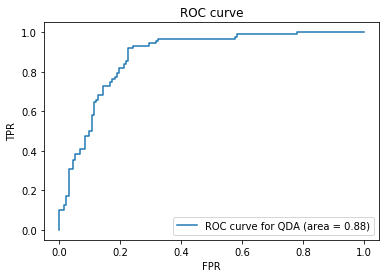

In [9]:
plt.plot(fprs,tprs,label= "ROC curve for QDA" + " (area = %0.2f)" %float(auc))
plt.legend()
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")

### B.

Perform Gaussian Mixture Discriminant Analysis on this set as described in the `gaussian_mixture_model_EM_algorithm` notebook. Use two components for positives and two components for negatives. Calculate the confusion matrix, AUC score and plot the ROC curve. 

First of all, we fit:

In [10]:
from sklearn.mixture import GaussianMixture



features0_cmp = GaussianMixture(n_components=2, max_iter=100, tol=0.0001)
features1_cmp = GaussianMixture(n_components=2, max_iter=100, tol=0.0001)

features0 = train_data[train_labels==0]
features1 = train_data[train_labels==1]

features0_cmp.fit(features0)
features1_cmp.fit(features1)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.0001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

We copy the functions given in the notebook:

In [11]:
def make_pdf(cmp):
    """
    Takes a GaussianMixture object and returns corresponding
    probability distribution function
    """
    n_cmp = cmp.n_components
    dists = [st.multivariate_normal(cmp.means_[i], cmp.covariances_[i]) for i in range(n_cmp)]
    def pdf(x):
        p = 0.0
        for i in range(n_cmp):
            p+= cmp.weights_[i]*dists[i].pdf(x)
        return p
    
    return pdf


def make_predict_proba(cmp0, cmp1, pi0=0.5, pi1=.5):
    """
    Takes two GaussianMixture object and corresponding priors and returns 
    pdf for conditional probability P(c=1|x)
    """
    pdf0 = make_pdf(cmp0)
    pdf1 = make_pdf(cmp1)
    def p(x):
        p0=pi0*pdf0(x)
        p1=pi1*pdf1(x)
        return p1/(p1+p0)    
        
    return p

And now we can apply them to our data. Since *plot_confusion_matrix* requires to add the classifier as a variable, in this case I will use the package seaborn to plot it. The values to be plotted are obtained with the *confusion_matrix* function from sklearn. For the AUC score and the ROC curve we can use the lines we have used before (of course, variables need to be changed):

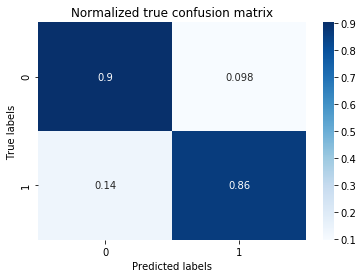

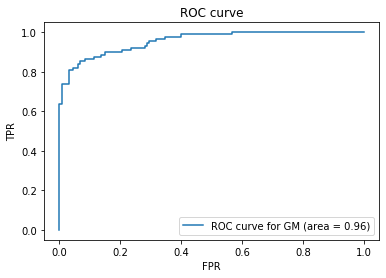

The AUC score is: 0.9555785123966941


In [12]:
import seaborn as sns




mgd_predict_proba = make_predict_proba(features0_cmp, features1_cmp, 0.5, 0.5)
mgd_proba = mgd_predict_proba(test_data)
cm = confusion_matrix(test_labels, mgd_proba>0.5, normalize='true')
plt.title("Normalized true confusion matrix")
f = sns.heatmap(cm, cmap=plt.cm.Blues,annot=True)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()



fprs_gauss, tprs_gauss, thds_gauss  = roc_curve(test_labels, mgd_proba,pos_label = 1)  
auc_gauss = roc_auc_score(test_labels,mgd_proba)
plt.plot(fprs_gauss,tprs_gauss,label= "ROC curve for GM" + " (area = %0.2f)" %float(auc_gauss))   

    
plt.legend()
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

print("The AUC score is:", auc_gauss)

As we should have expected, the AUC score is better than for QDA.

### C.

Use k-fold cross validation to find the optimal number of gaussian components for each class. As before calculate the confusion matrix, AUC score and plot the ROC curve for the best classifier. 

I will define two functions: one for creating two mixtures with a certain number of components, and another one that performs the cross validation on two given mixtures and returns the average f1_score. 

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score


def mixture_maker(components_0,components_1):
    x0_cmp = GaussianMixture(n_components=components_0, max_iter=100, tol=0.0001)
    x1_cmp = GaussianMixture(n_components=components_1, max_iter=100, tol=0.0001)
    
    return x0_cmp,x1_cmp

def k_fold_preparator(splits,x0_cmp,x1_cmp):
  f1 = 0
  skf = StratifiedKFold(n_splits= splits) #returned folds will be the same
    
  for train_index, test_index in skf.split(features,labels): #loop that runs for each fold
        x_train, x_test = features.iloc[train_index],features.iloc[test_index] #separation of train and test
        y_train, y_test = labels.iloc[train_index],labels.iloc[test_index]

        x0 = x_train[y_train==0] #separation of classes
        x1 = x_train[y_train==1]

        x0_cmp.fit(x0)
        x1_cmp.fit(x1)
        
        mgd_predict_proba_2 = make_predict_proba(x0_cmp, x1_cmp, 0.5, 0.5)
        mgd_proba_2 = mgd_predict_proba_2(x_test)
        f1 += f1_score(y_test, mgd_proba_2>0.5, average='macro') #we add all and then we return the average
        
  return f1/splits      
        
         

Here we prepare all the possible combinations of components. The limit is 5 components:

In [14]:
mixture_combinations= []

for i in range(1,6): 
    for j in range(1,6):
         x0_cmp,x1_cmp = mixture_maker(i,j)
         mixture_combinations.append([x0_cmp,x1_cmp])
            

    

Now that we have all possible combinations inside a list, we can run the function that returns their f1_scores and choose which one is the best. The number of splits will be ten.

In [15]:
f1s = []
for k in range(len(mixture_combinations)):
    f1_average = k_fold_preparator(10,mixture_combinations[k][0],mixture_combinations[k][1])
    f1s.append(f1_average)
    
  

In [16]:
print("The best F1 score was", f1s[np.argmax(f1s)])  
print("Number of components for class 0:", np.argmax(f1s) // 5) #If this part is confusing,
                                                                #please have at look at how mixture_combinations is built
print("Number of components for class 1:", np.argmax(f1s) % 5)


The best F1 score was 0.9354251334694175
Number of components for class 0: 4
Number of components for class 1: 4


Now that we know which combination is the best, we can calculate the confusion matrix, AUC score and plot the ROC curve:

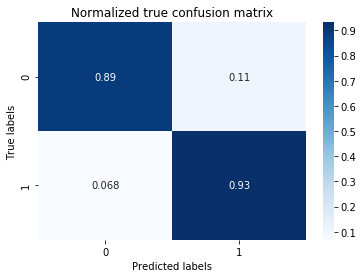

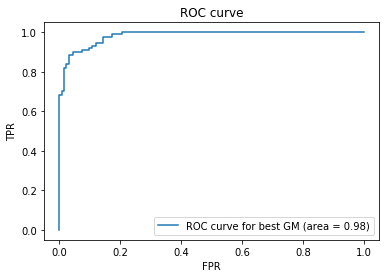

The AUC score is: 0.9819214876033058


In [17]:
features0_cmp_new = GaussianMixture(n_components=np.argmax(f1s) // 5, max_iter=100, tol=0.0001)
features1_cmp_new = GaussianMixture(n_components=np.argmax(f1s) % 5, max_iter=100, tol=0.0001)

features0_cmp_new.fit(features0)
features1_cmp_new.fit(features1)


mgd_predict_proba_new = make_predict_proba(features0_cmp_new, features1_cmp_new, 0.5, 0.5)
mgd_proba_new = mgd_predict_proba_new(test_data)
cm_new = confusion_matrix(test_labels, mgd_proba_new>0.5, normalize='true')
plt.title("Normalized true confusion matrix")
f = sns.heatmap(cm_new, cmap=plt.cm.Blues,annot=True)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()



fprs_new, tprs_new, thds_new  = roc_curve(test_labels, mgd_proba_new,pos_label = 1)  
auc_new = roc_auc_score(test_labels,mgd_proba_new)
    
plt.plot(fprs_new,tprs_new,label= "ROC curve for best GM" + " (area = %0.2f)" %float(auc_new))
plt.legend()
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

print("The AUC score is:", auc_new)

__Hint__ use the `StratifiedKFold` function from scikit-learn library to generate folds. 

I will plot the three ROC curves for comparison:

## D.  

Assume that 1% of all the customers in your store presents a counterfeit 100PLN bill. If you accept the counterfeit bill you loose 100PLN. If you reject a valid bill,  you may loose the purchase, you estimate this loss as 15PLN on average. For each of the three classifiers find the threshold that minimises your losses and calculates the minimum loss for each classifier. Show the optimal classifiers points on the ROC curves.

I guess that the function that we have to minimize is the following:

$Losses = 100*FN + 15*FP$

We know that FN + TP amounts to 0.01 of the bills, and TN + FP to 0.99. If we calculate the rates for each classifier, we can know which percentage of the total will be classified as FN,TP,TN AND FP:

$FN = 0.01*FNR$ 

$TP = 0.01*TPR$ 

$TN = 0.99*TNR$ 

$FP = 0.99*FPR$ 

Since we have already calculated  FNR = 1-TPR, FPR and thresholds in the previous exercises, what we can do is run a loop that goes all over them and calculate the losses. 

Please, bear in mind that FN, TP, TN and FP is given as a percentage of the total.




In [18]:
def losses(loss_not_accept,loss_accept,per_counter,per_true,fprs,tprs,thds):
    loss= loss_not_accept*fprs*per_true + loss_accept*(1-tprs)*per_counter
    return loss, thds

def losses_minimizer(loss_not_accept,loss_accept,per_counter,per_true,fprs_list,tprs_list,thds_list):
    loss_min = 0
    thds_min = 0
    Pass=True
   
    for i in range(len(fprs_list)):
        loss,thds = losses(loss_not_accept,loss_accept,per_counter,per_true,fprs_list[i],tprs_list[i],thds_list[i])
        if loss < loss_min or Pass == True:
            Pass = False
            loss_min = loss
            thds_min = thds
            
            
    return loss_min,thds_min     

In [19]:
loss_min_qda,thds_min_qda = losses_minimizer(15,100,0.01,0.99,fprs,tprs,thds)
loss_min_gauss,thds_min_gauss = losses_minimizer(15,100,0.01,0.99,fprs_gauss,tprs_gauss,thds_gauss)
loss_min_new,thds_min_new = losses_minimizer(15,100,0.01,0.99,fprs_new,tprs_new,thds_new)
                                             
print("For QDA, the minimum loss per banknote is", loss_min_qda, "with a threshold of" , thds_min_qda)
print("For Gauss, the minimum loss per banknote is", loss_min_gauss, "with a threshold of" , thds_min_gauss)
print("For the best Gauss, the minimum loss per banknote is", loss_min_new, "with a threshold of" , thds_min_new)



For QDA, the minimum loss per banknote is 0.8977272727272727 with a threshold of 0.9766165654332428
For Gauss, the minimum loss per banknote is 0.3636363636363637 with a threshold of 0.9262468394680106
For the best Gauss, the minimum loss per banknote is 0.31818181818181823 with a threshold of 0.9686933982496163


The result makes more sense if we compare it with a penalty of 1PLN for not taking the banknote:

In [20]:
loss_min_qda_2,thds_min_qda_2= losses_minimizer(1,100,0.01,0.99,fprs,tprs,thds)
loss_min_gauss_2,thds_min_gauss_2 = losses_minimizer(1,100,0.01,0.99,fprs_gauss,tprs_gauss,thds_gauss)
loss_min_new_2,thds_min_new_2 = losses_minimizer(1,100,0.01,0.99,fprs_new,tprs_new,thds_new)
                                             
print("For QDA, the minimum loss per banknote is", loss_min_qda_2, "with a threshold of" , thds_min_qda_2)
print("For Gauss, the minimum loss per banknote is", loss_min_gauss_2, "with a threshold of" , thds_min_gauss_2)
print("For the best Gauss, the minimum loss per banknote is", loss_min_new_2, "with a threshold of" , thds_min_new_2)


For QDA, the minimum loss per banknote is 0.30454545454545456 with a threshold of 0.25856507588672417
For Gauss, the minimum loss per banknote is 0.2152272727272727 with a threshold of 0.6172421210092456
For the best Gauss, the minimum loss per banknote is 0.14363636363636365 with a threshold of 0.8260528612184743


As we can see, the thresholds drops when the penalty for not accepting the banknote is reduced. Since we don't lose barely any money, it is better to decline the bill even if the probability of it being counterfeit is smaller. If we take the example for 0PLN, we can see that the threshold actually goes to a minimum.

Let's now plot the optimal points on the ROC curves:

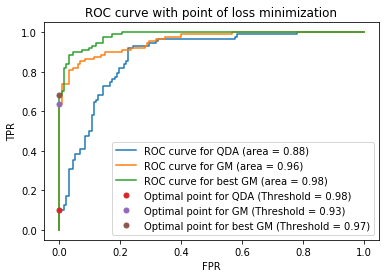

In [21]:
plt.plot(fprs,tprs,label= "ROC curve for QDA" + " (area = %0.2f)" %float(auc))
plt.plot(fprs_gauss,tprs_gauss,label= "ROC curve for GM" + " (area = %0.2f)" %float(auc_gauss))
plt.plot(fprs_new,tprs_new,label= "ROC curve for best GM" + " (area = %0.2f)" %float(auc_new))
plt.plot(fprs[thds == thds_min_qda],tprs[thds == thds_min_qda],'.',markersize=10,
         label= "Optimal point for QDA" + " (Threshold = %0.2f)" %float(thds_min_qda))
plt.plot(fprs_gauss[thds_gauss == thds_min_gauss],tprs_gauss[thds_gauss == thds_min_gauss],'.',markersize=10,
         label= "Optimal point for GM" + " (Threshold = %0.2f)" %float(thds_min_gauss))
plt.plot(fprs_new[thds_new == thds_min_new],tprs_new[thds_new == thds_min_new],'.',markersize=10,
         label= "Optimal point for best GM" + " (Threshold = %0.2f)" %float(thds_min_new))

plt.legend()
plt.title("ROC curve with point of loss minimization")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


If we have a look at the plot, ot is clear that the bigger the TPR and the smaller the FPR, the better, which makes total sense if we have a look at the loss function.